In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline

from minisom import MiniSom
from sklearn.preprocessing import minmax_scale, scale

from collections import defaultdict, Counter
from sklearn.datasets import load_breast_cancer
data, target = load_breast_cancer(True)
from pylab import plot, axis, show, pcolor, colorbar, bone
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster.supervised import check_clusterings

In [2]:
df = pd.read_csv('summary_monthly1.csv', skipinitialspace=True, index_col=False, na_values= "?")



In [3]:
data = df.iloc[:, 2:-4]
target = df.iloc[:, -1]

In [4]:
data = np.array(data)
data.shape


(626, 61)

In [148]:
import numpy as np
import pandas as pd


class SOM(object):

    def __init__(self, map_size, lr=1, radius=10, type_neighber_fun="gaussian_neighber", not_load=True):
        
        self.map = np.random.random(size = (map_size[0], map_size[1], map_size[2])) if not_load else None
        #np.random.seed(42)
        self.lr0 = lr
        self.lr = self.lr0

        self.R0 = radius
        self.R = self.R0
        
        self.type_neighber_fun = type_neighber_fun

    def train(self, X, T=1000):
        
        Js = []
        for t in range(T):
            prev_map = self.map
            shuffle_ind = np.random.randint(low = 0, high = len(X), size = len(X))
                
            for i in range(len(X)):
                x = X[shuffle_ind[i], :]

                winner = self.find_winner(x)
                
                if self.type_neighber_fun == "no_neighber":
                    NS = 0
                elif self.type_neighber_fun == "gaussian_neighber":
                    NS = self.get_NS3(winner)
                else:
                    NS = self.get_NS2(winner)
                
                       
                self.update_weights(x, NS, len(X))

                
            #self.lr = self.lr0 * (1 - t/T)
            #self.R = self.R0 * (1 - t/T)
            
            self.lr = self.lr0 * np.exp(-t/T)
            self.R = self.R0 * np.exp(-t/T)
            
            new_map = np.linalg.norm(prev_map - self.map)
            Js.append(new_map)
            
            if t % 100 == 0:
                print("Itration: %d, LR: %f, R: %f, J: %f" %(t, self.lr, self.R, Js[-1]))

        return Js


    def find_winner(self, x):
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        dists = np.sum((self.map - rep_x)**2, axis = 2)
        winner = np.unravel_index(np.argmin(dists, axis = None), dists.shape)

        return winner

    
    #plus neighberhood
    def get_NS(self, winner):
        NS = np.zeros(shape = (self.map.shape[0], self.map.shape[1]))
        iw, jw = winner[0], winner[1]

        NS[iw, jw] = 1

        for r in range(1, int(self.R)):

            if iw - r >= 0:
                NS[iw - r, jw] = self.gaussian_update_NS(self.dist_win(winner, (iw - r, jw)), r) if self.type_neighber_fun == "gaussian_neighber" else 1/r
            if iw + r < self.map.shape[0] - 1:
                NS[iw + r, jw] = self.gaussian_update_NS(self.dist_win(winner, (iw + r, jw)), r) if self.type_neighber_fun == "gaussian_neighber" else 1/r
            
            if jw - r >= 0:
                NS[iw, jw - r] = self.gaussian_update_NS(self.dist_win(winner, (iw, jw - r)), r) if self.type_neighber_fun == "gaussian_neighber" else 1/r
            if jw + r < self.map.shape[1] - 1:
                NS[iw, jw + r] = self.gaussian_update_NS(self.dist_win(winner, (iw, jw + r)), r) if self.type_neighber_fun == "gaussian_neighber" else 1/r

        return NS
    
    def gaussian_update_NS(self, dist_win, r):
        return np.exp(- np.square(dist_win) / 2 * np.square(r))
    
    #gaussian neighberhood
    def get_NS3(self, winner):
        
        win_matrix = np.tile(winner, (self.map.shape[0] * self.map.shape[1], 1))
        map_neuron = []
        
        for i in range(self.map.shape[0]):
            for j in range(self.map.shape[1]):
                map_neuron.append(np.array([i, j]))
        
        map_neuron = np.array(map_neuron)
        dists_neurons = np.array(np.sum(np.square(win_matrix - map_neuron), 1)).reshape(self.map.shape[0], self.map.shape[1])
                
        return np.exp(- np.square(dists_neurons) / (2 * np.square(self.R)))
    
    #circle neighberhood
    def get_NS2(self, winner):
        NS = np.zeros(shape = (self.map.shape[0], self.map.shape[1]))
        iw, jw = winner[0], winner[1]
        
        NS[iw, jw] = 1
        
        R = int(self.R)
        for ri in range(-R, R):
            for rj in range(-R, R):
                if(0 <= iw + ri < self.map.shape[0]) and(0 <= jw + rj < self.map.shape[1]):
                    NS[iw + ri, jw + rj] = 0 if np.sqrt(np.square(ri) + np.square(rj)) > R else self.gaussian_update_NS(self.dist_win(winner, (iw + rj, jw + rj)), ri) if self.type_neighber_fun == "gaussian_neighber" else np.sqrt(np.square(ri) + np.square(rj))
                    #self.gaussian_update_NS(self.dist_win(winner, (iw + rj, jw + rj)), ri) 
                    
        return NS
                        
    def dist_win(self, winner, neuron):
        return np.sum(np.square(np.array(winner) - np.array(neuron)))

    def update_weights(self, x, n_strength, X_len):

        NS = np.tile(n_strength, [self.map.shape[2], 1, 1]).transpose()
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        Delta = rep_x - self.map
        
        if self.type_neighber_fun == "no_neighber":
            self.map = self.map + (self.lr / X_len) * Delta
        else:
            self.map = self.map + (self.lr / X_len) * np.multiply(NS, Delta)
        
        
    def feature_extraction(self, x):
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        dists = np.sum((self.map - rep_x)**2, axis = 2)
        return 1 / (1 + dists)
    

        return NS
    
    def labels_map(self, data, labels):
        
        winmap = defaultdict(list)
        print(winmap)
        for x, l in zip(data, labels):
            winmap[tuple(self.find_winner(x))].append(l)
        for position in winmap:
            winmap[position] = Counter(winmap[position])
        return winmap
    
    def purity(self, data, label):
        
        purit_matrix = np.zeros(shape = (self.map.shape[0], self.map.shape[1]))
        labels_map = self.labels_map(data, label)
        label_names = np.unique(label)

        total = []
        for position in labels_map.keys():
            label_fracs = [labels_map[position][l] for l in label_names]
            total.append(label_fracs)
            
            
        for i, position in enumerate(labels_map.keys()):

            p_x, p_y = position[0], position[1]
            purit_matrix[p_x][p_y] = max(total[i]) / sum(total[i])
            
    
        return np.sum(purit_matrix) / (len(labels_map.keys())), ((self.map.shape[0]*self.map.shape[1]) - len(labels_map.keys()))
    
    
    def get_weights(self):
        return self.map
    
    def visualize(self, X, y):
        pass
    
    def distance_map(self):
        
        we = self.get_weights()
        um = np.zeros((we.shape[0], we.shape[1]))
        it = np.nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if (ii >= 0 and ii < we.shape[0] and
                            jj >= 0 and jj < we.shape[1]):
                        w_1 = we[ii, jj, :]
                        w_2 = we[it.multi_index]
                        w_f = w_1 - w_2
                        um[it.multi_index] += np.sqrt(np.dot(w_f, w_f.T))
            it.iternext()
        um = um/um.max()
        return um
    
    def load_weights(self, weights):
        self.map = weights
    



In [243]:
som_shape = (9, 9)
som = SOM(map_size = [som_shape[0], som_shape[1], data.shape[1]], lr=0.1, radius= 4)
Js = som.train(data, T=500)

Itration: 0, LR: 0.100000, R: 4.000000, J: 0.627475
Itration: 100, LR: 0.081873, R: 3.274923, J: 0.084063
Itration: 200, LR: 0.067032, R: 2.681280, J: 0.032655
Itration: 300, LR: 0.054881, R: 2.195247, J: 0.015519
Itration: 400, LR: 0.044933, R: 1.797316, J: 0.010147


In [244]:
data.shape


(626, 61)

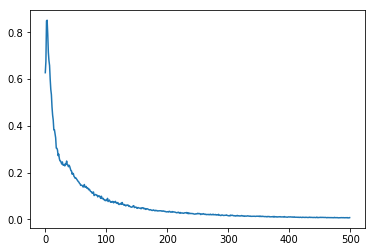

In [245]:
plt.plot(Js)
plt.show()

In [246]:
purity, number_die_neuron = som.purity(data, target)
print("purity: %f, number_die_neuron : %d" %(purity, number_die_neuron))

defaultdict(<class 'list'>, {})
purity: 0.411416, number_die_neuron : 29


In [247]:
import pickle as pkl

with open('weights_data.pkl','wb') as f:
        pkl.dump(som.get_weights(), f)

In [248]:
with open('label_map.pkl','wb') as f:
        pkl.dump(som.labels_map(data, target), f)

defaultdict(<class 'list'>, {})


In [249]:
import pickle as pkl

with open('weights_data.pkl','rb') as f:
         w = pkl.load(f)

In [250]:
import math

import numpy as np
from matplotlib import cm, pyplot as plt
from matplotlib.collections import RegularPolyCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_hex_map(d_matrix, titles=[], colormap=cm.gray, shape=[1, 1], comp_width=5, hex_shrink=1.0, fig=None,
                 colorbar=True):
    """
    Plot hexagon map where each neuron is represented by a hexagon. The hexagon
    color is given by the distance between the neurons (D-Matrix)
    Args:
    - grid: Grid dictionary (keys: centers, x, y ),
    - d_matrix: array contaning the distances between each neuron
    - w: width of the map in inches
    - title: map title
    Returns the Matplotlib SubAxis instance
    """

    d_matrix = np.flip(d_matrix, axis=0)

    def create_grid_coordinates(x, y):
        coordinates = [x for row in -1 * np.array(list(range(x))) for x in
                       list(zip(np.arange(((row) % 2) * 0.5, y + ((row) % 2) * 0.5), [0.8660254 * (row)] * y))]
        return (np.array(list(reversed(coordinates))), x, y)

    if d_matrix.ndim < 3:
        d_matrix = np.expand_dims(d_matrix, 2)

    #if len(titles) != d_matrix.shape[2]:
        #titles = [""] * d_matrix.shape[2]

    n_centers, x, y = create_grid_coordinates(*d_matrix.shape[:2])

    # Size of figure in inches
    if fig is None:
        xinch, yinch = comp_width * shape[1], comp_width * (x / y) * shape[0]
        fig = plt.figure(figsize=(xinch, yinch), dpi=72.)

    for comp, title in zip(range(d_matrix.shape[2]), titles):
        ax = fig.add_subplot(shape[0], shape[1], comp + 1, aspect='equal')

        # Get pixel size between two data points
        xpoints = n_centers[:, 0]
        ypoints = n_centers[:, 1]
        ax.scatter(xpoints, ypoints, s=0.0, marker='s')
        ax.axis([min(xpoints) - 1., max(xpoints) + 1.,
                 min(ypoints) - 1., max(ypoints) + 1.])
        xy_pixels = ax.transData.transform(np.vstack([xpoints, ypoints]).T)
        xpix, ypix = xy_pixels.T

        # discover radius and hexagon
        apothem = hex_shrink * (xpix[1] - xpix[0]) / math.sqrt(3)
        area_inner_circle = math.pi * (apothem ** 2)
        dm = d_matrix[:, :, comp].reshape(np.multiply(*d_matrix.shape[:2]))
        collection_bg = RegularPolyCollection(
            numsides=6,  # a hexagon
            rotation=0,
            sizes=(area_inner_circle,),
            array=dm,
            cmap=colormap,
            offsets=n_centers,
            transOffset=ax.transData,
        )
        ax.add_collection(collection_bg, autolim=True)

        ax.axis('off')
        ax.autoscale_view()
        ax.set_title(titles)#, fontdict={"fontsize": 3 * comp_width})
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(collection_bg, cax=cax)
        if not colorbar:
            cbar.remove()

        #cbar.ax.tick_params(labelsize=3 * comp_width)

    return ax, list(reversed(n_centers))

In [251]:
COLUMNS = np.array(df.columns)
COLUMNS = COLUMNS[2:-4]
feature_names = COLUMNS


C:\Users\Amir Houseen\AppData\Roaming\Python\Python36\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


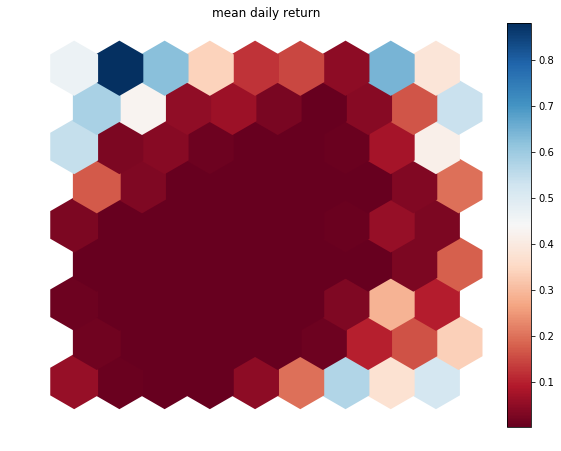

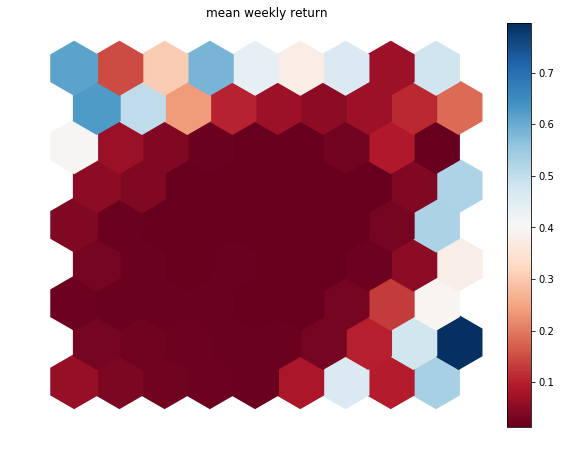

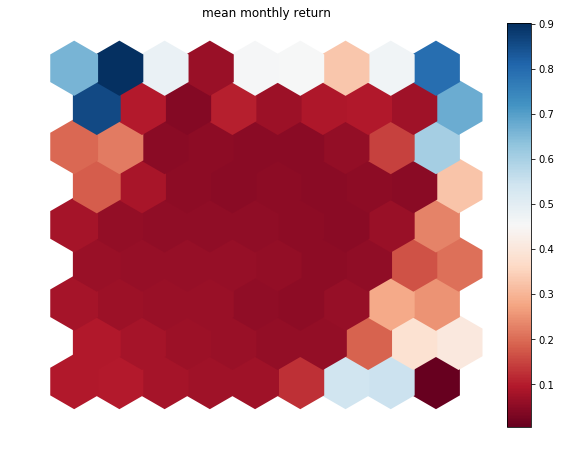

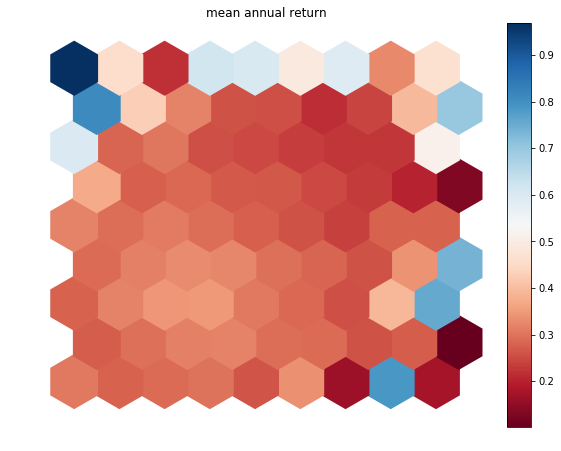

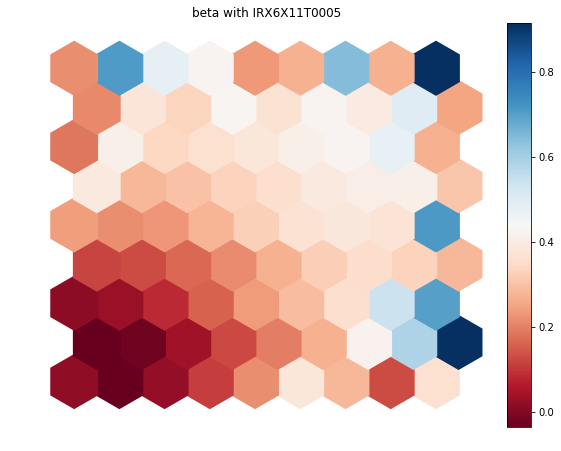

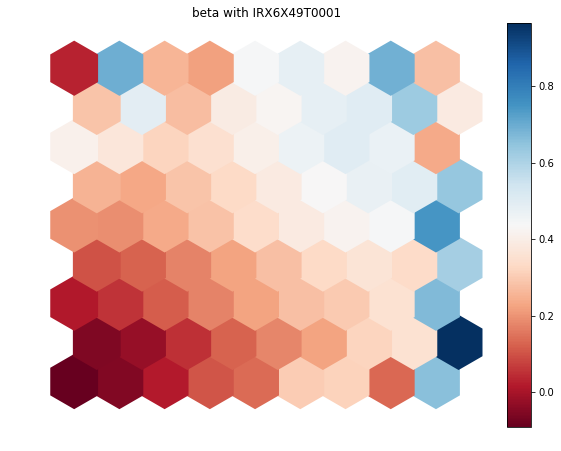

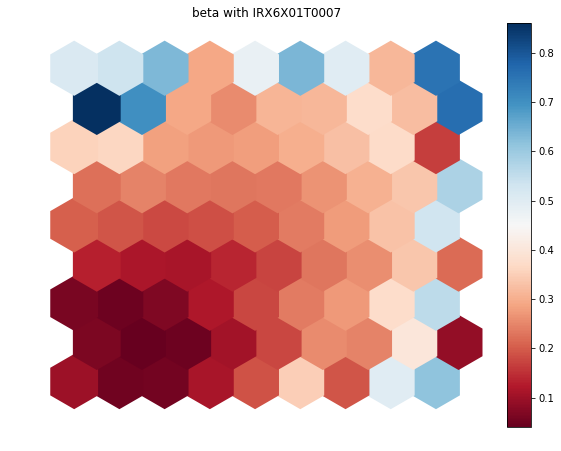

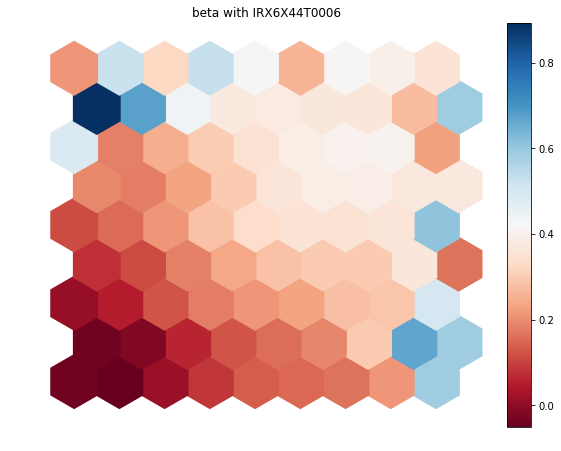

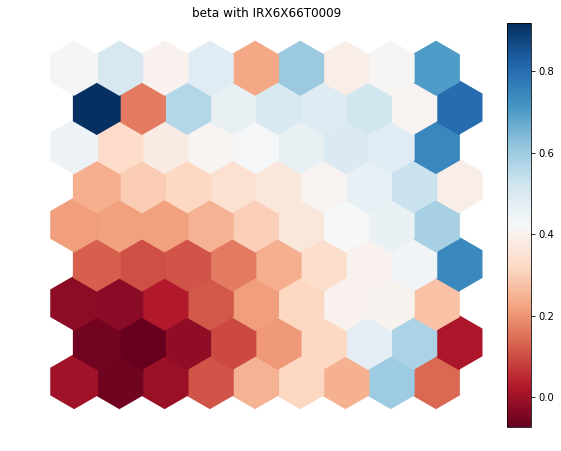

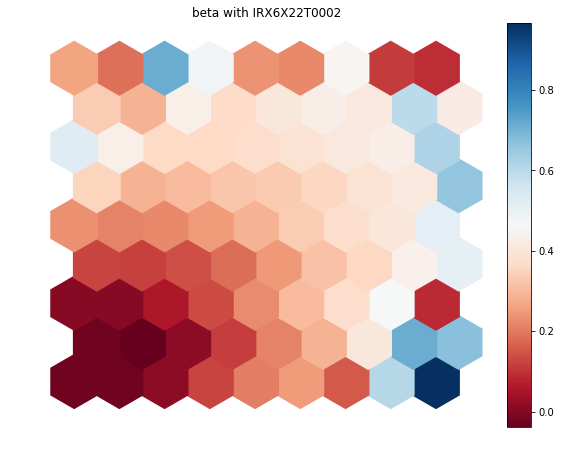

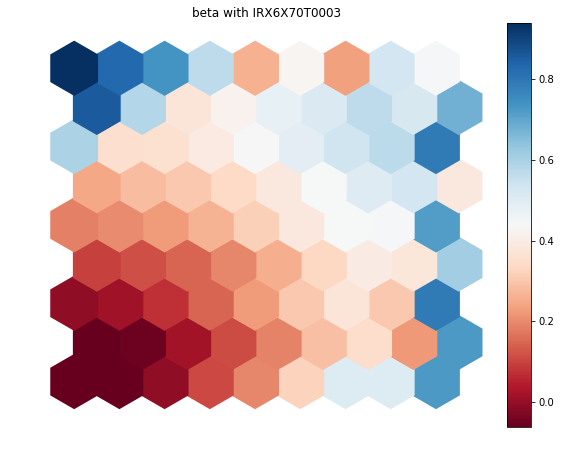

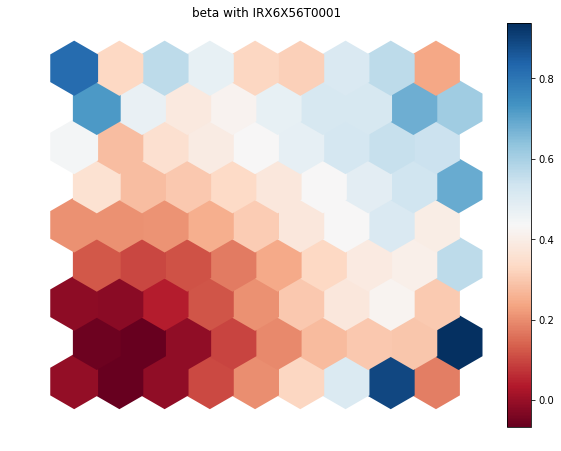

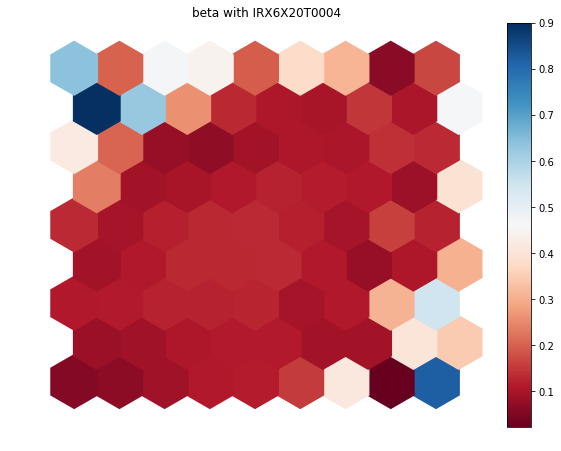

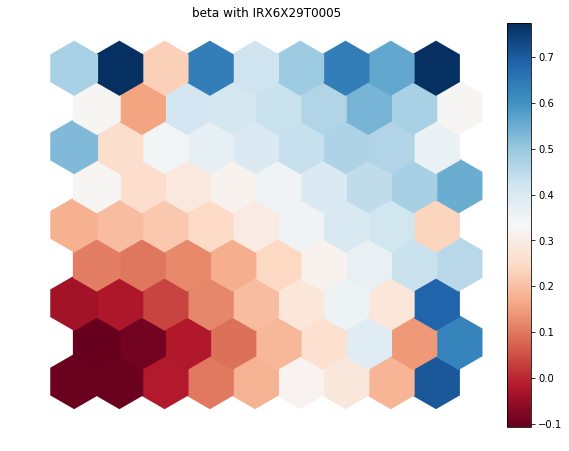

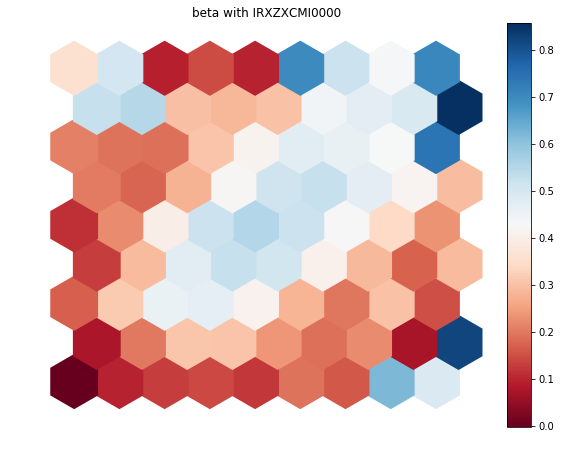

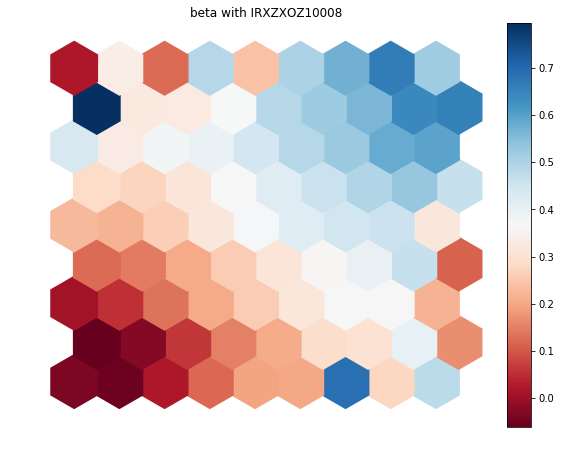

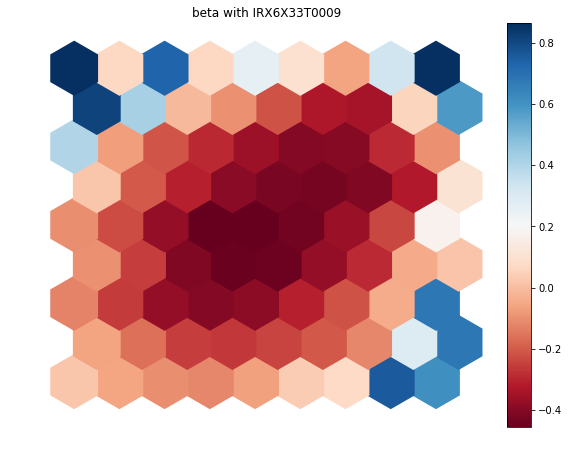

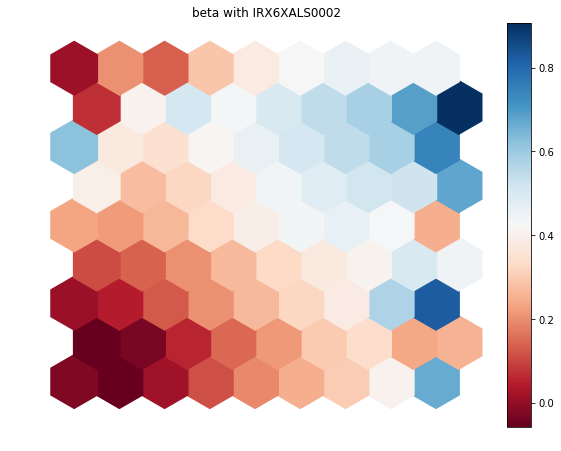

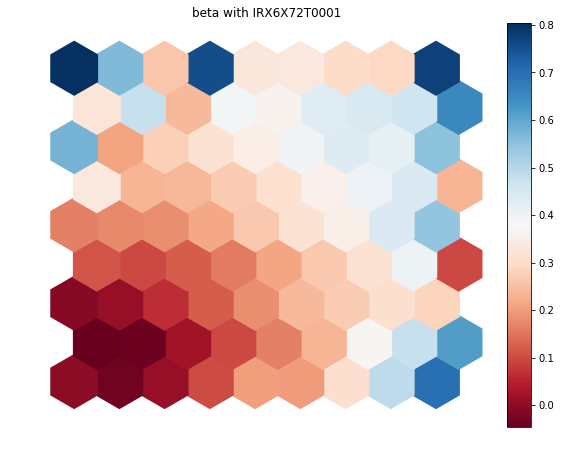

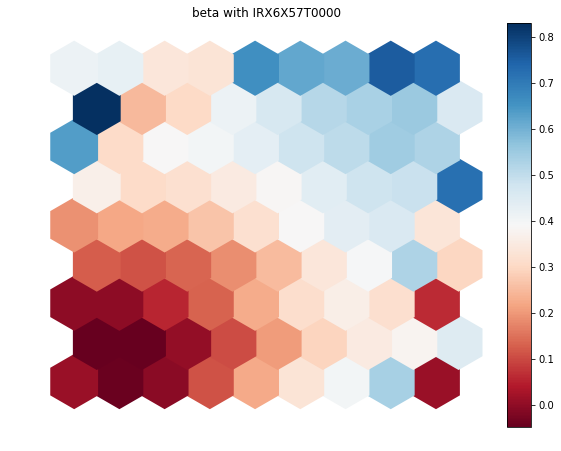

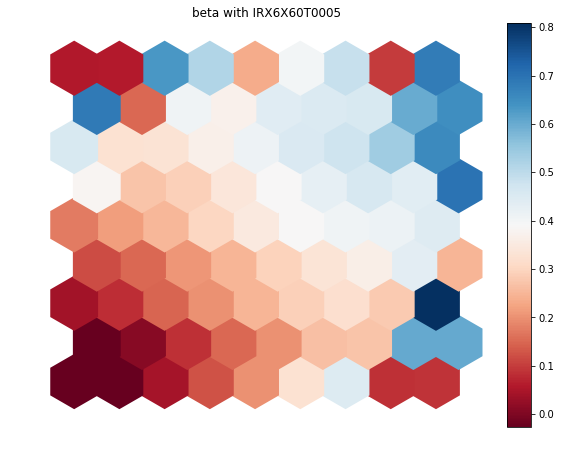

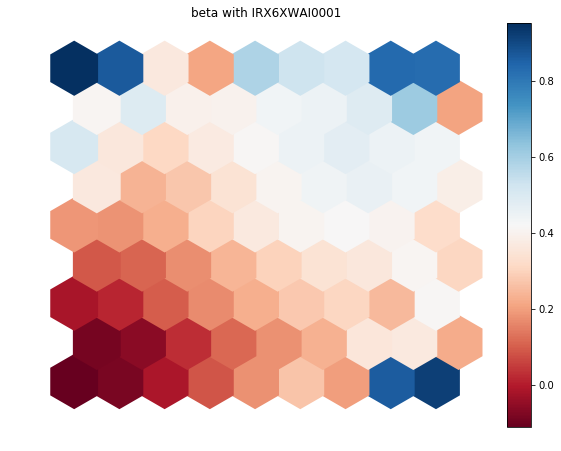

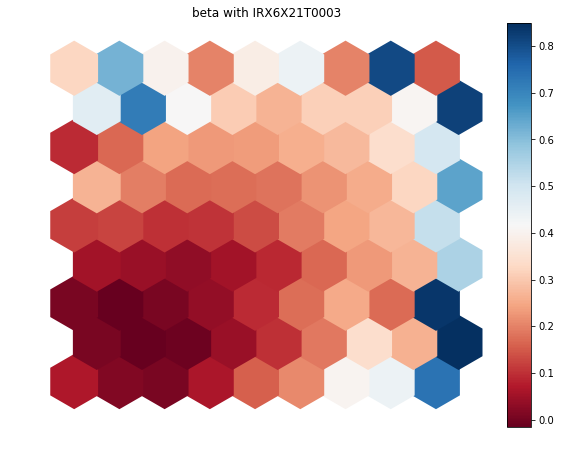

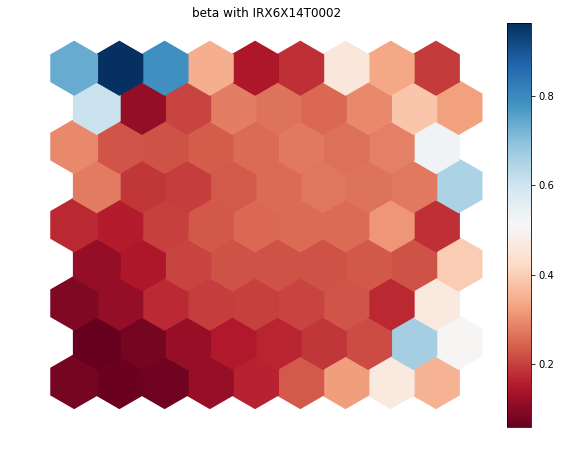

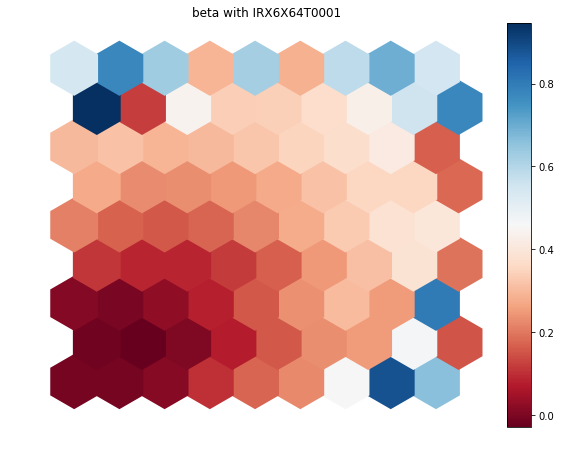

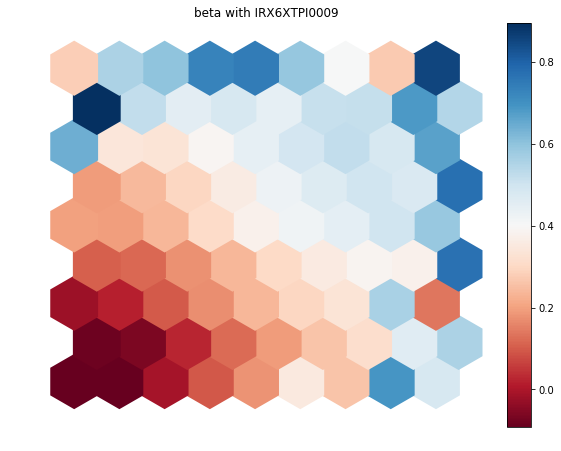

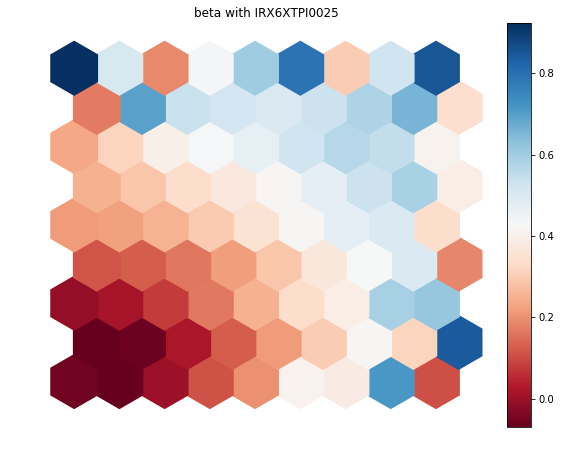

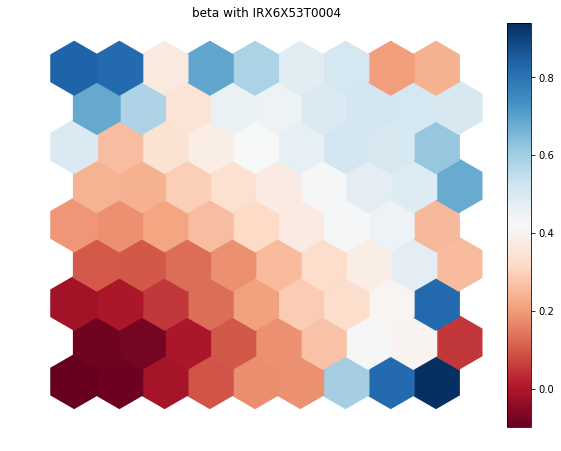

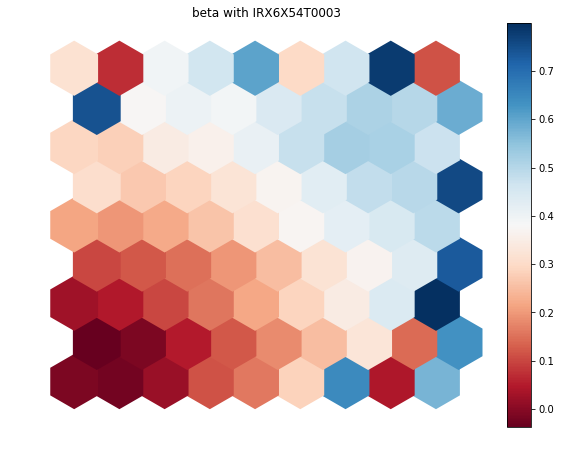

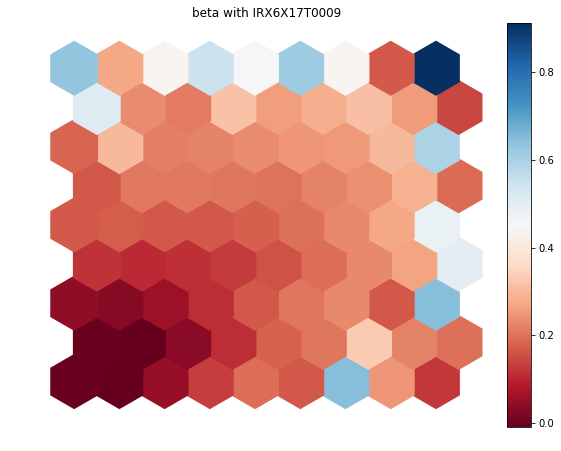

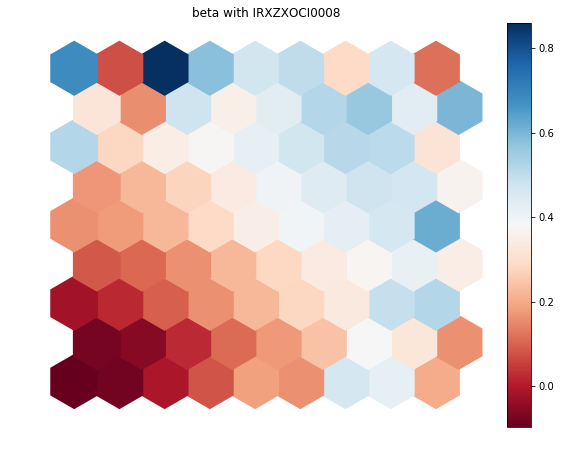

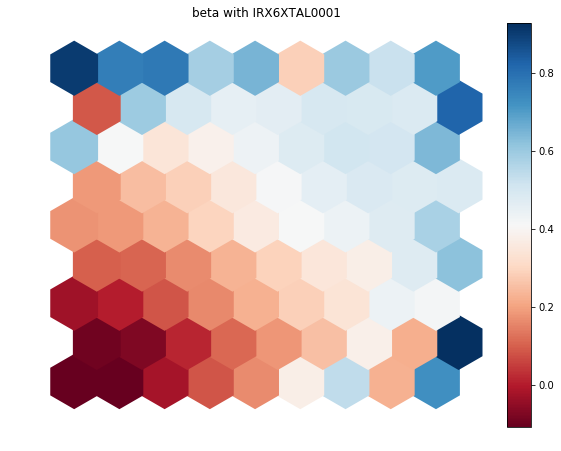

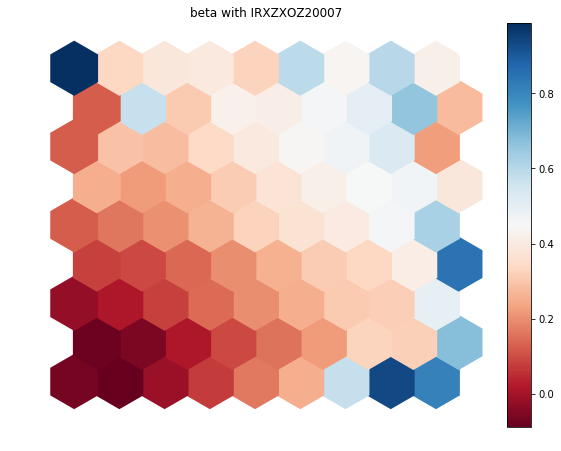

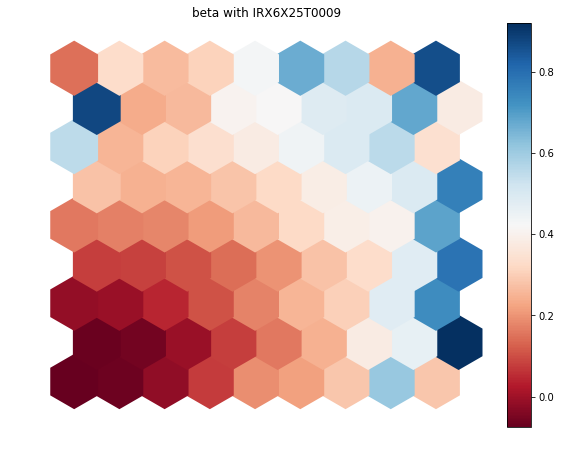

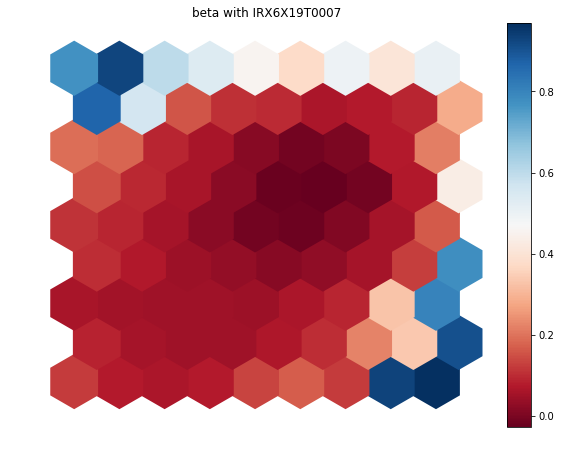

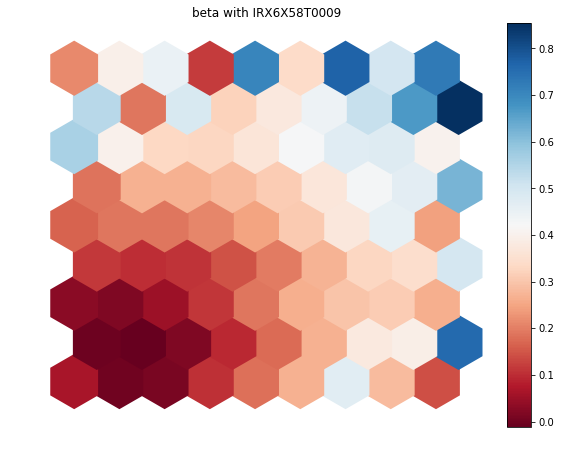

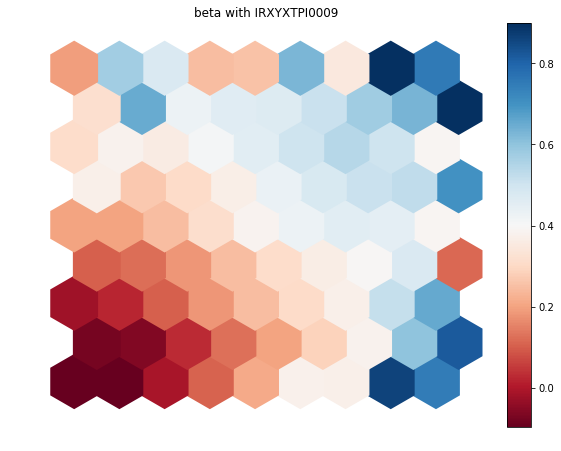

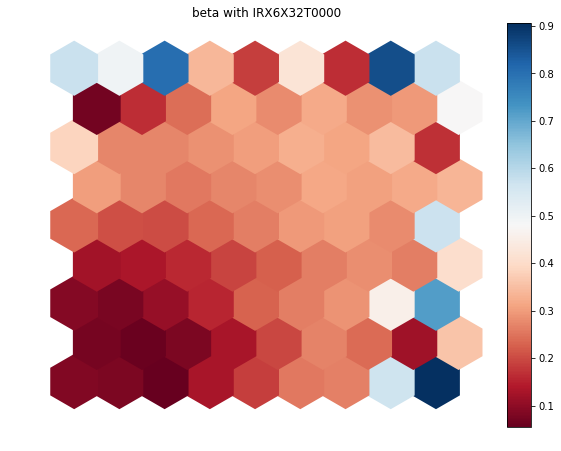

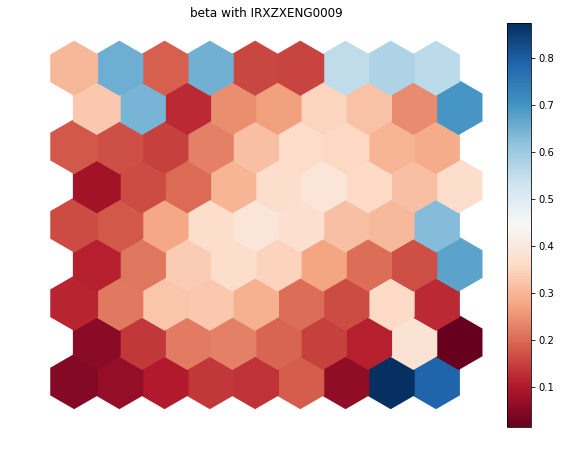

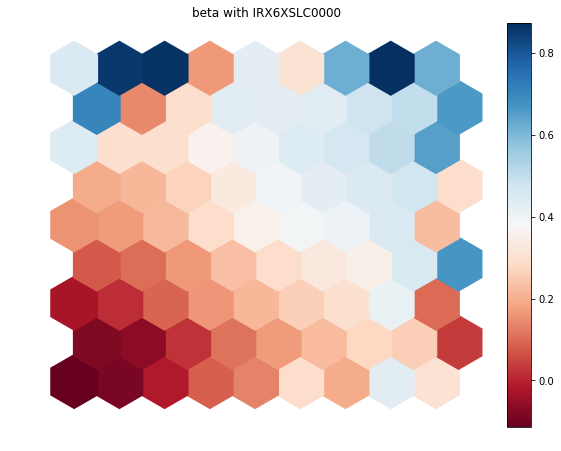

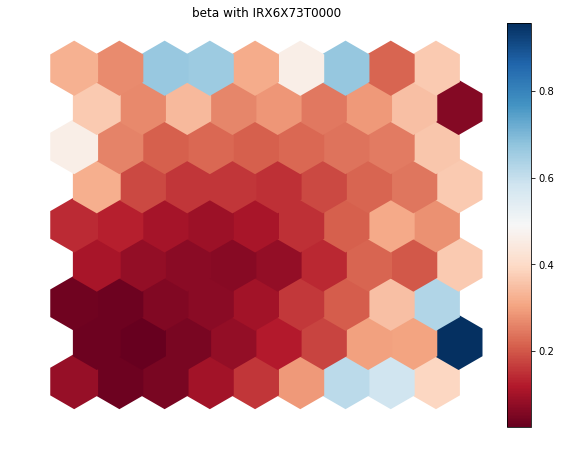

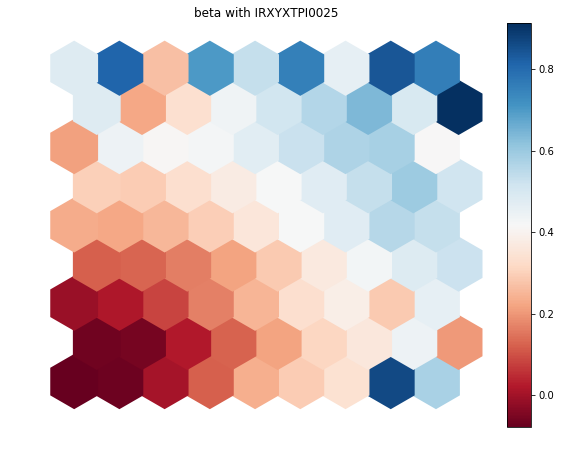

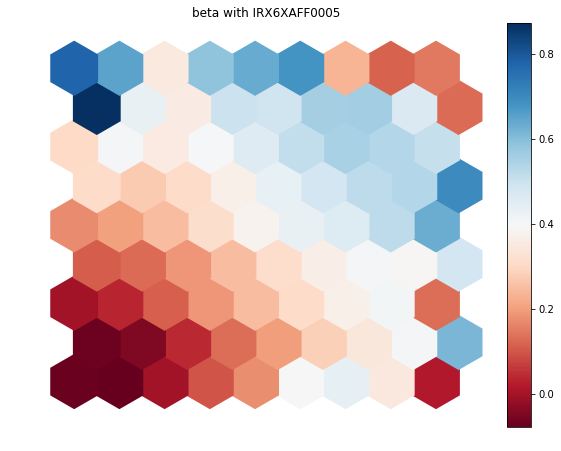

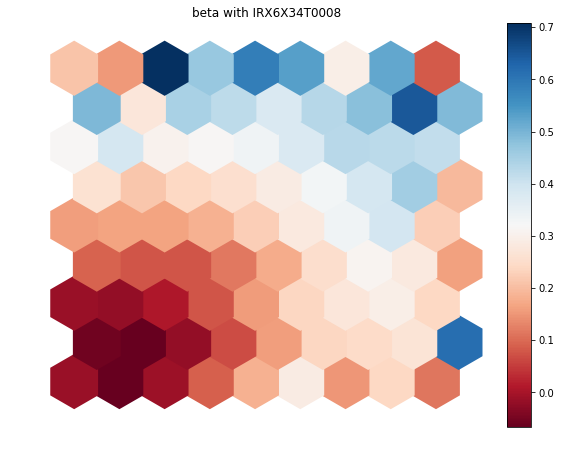

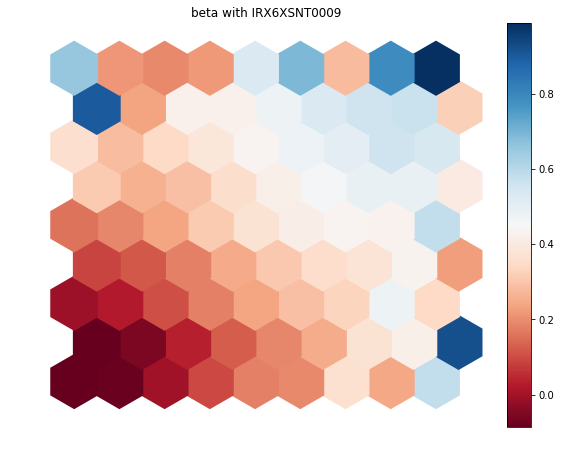

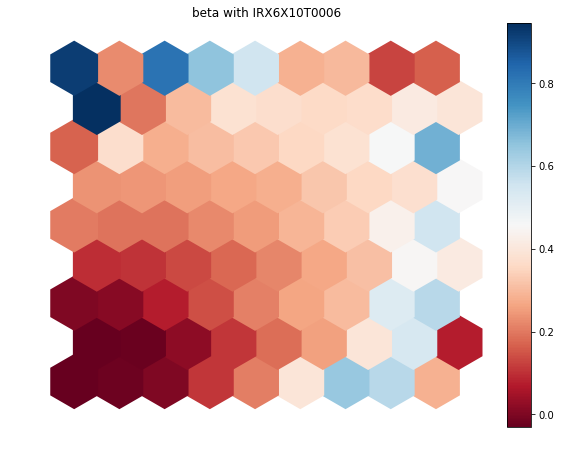

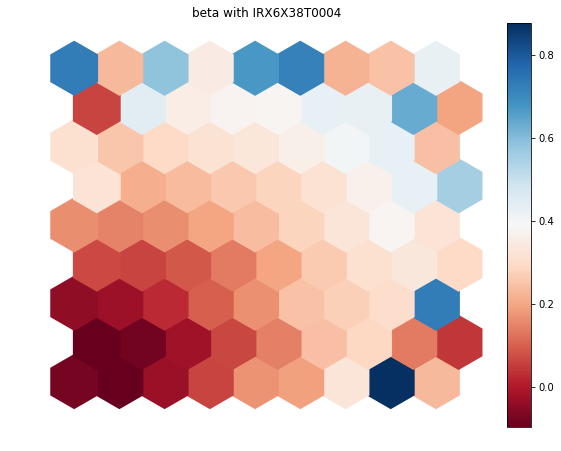

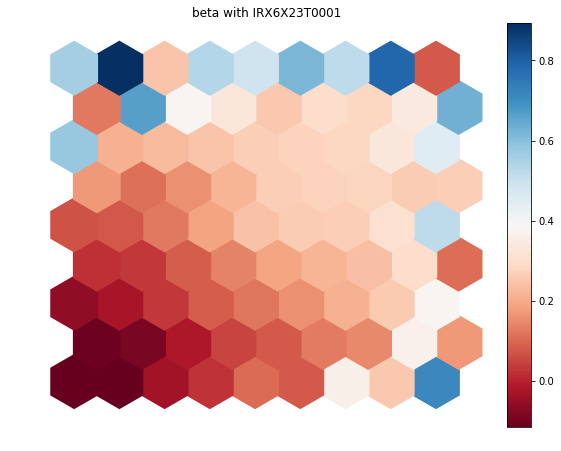

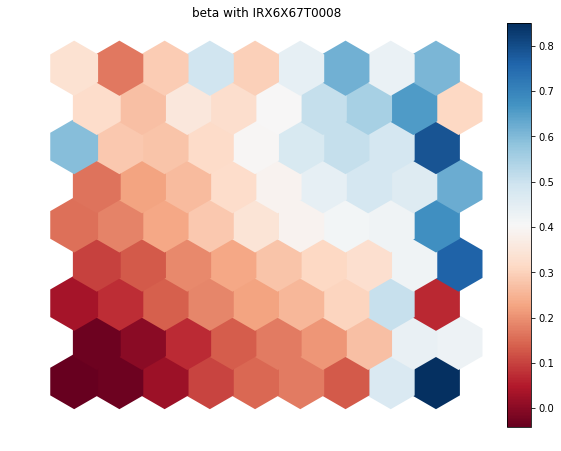

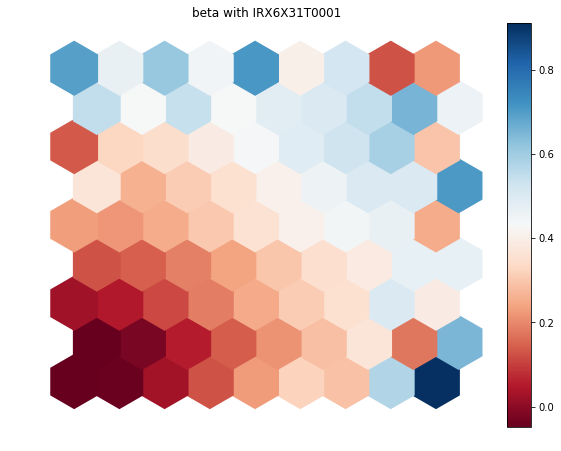

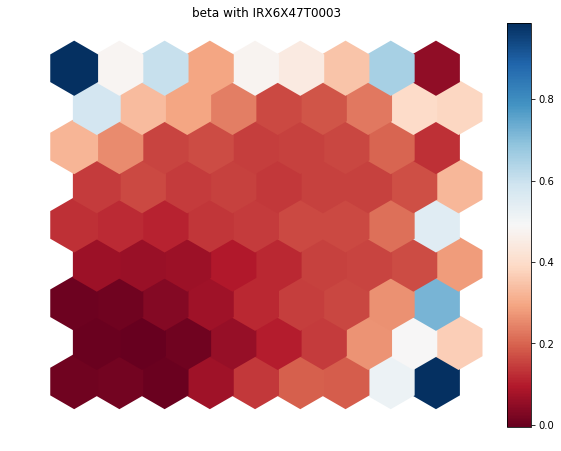

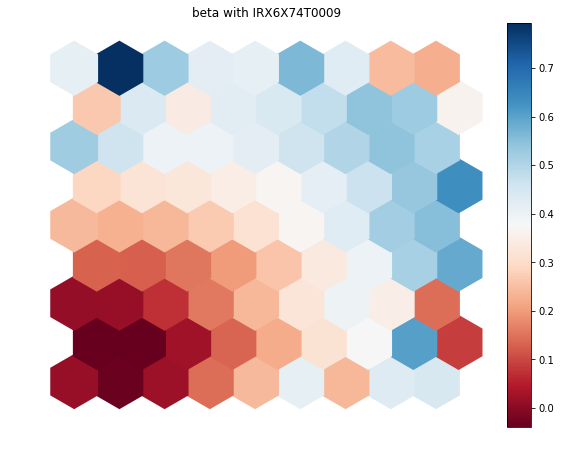

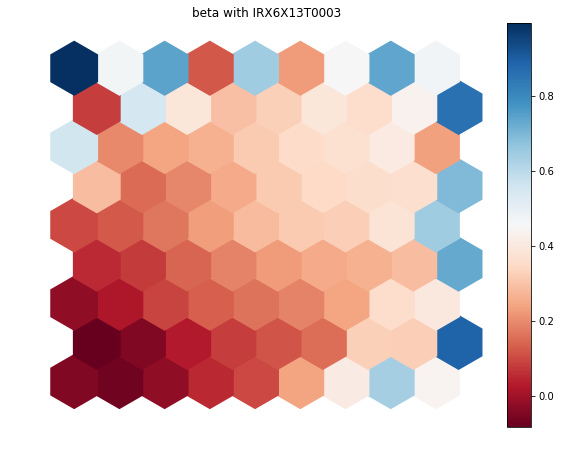

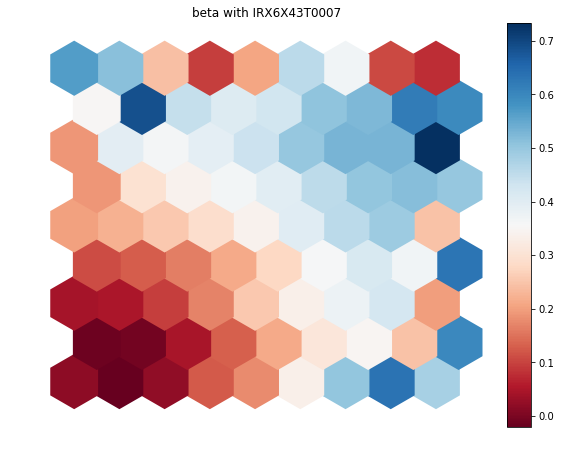

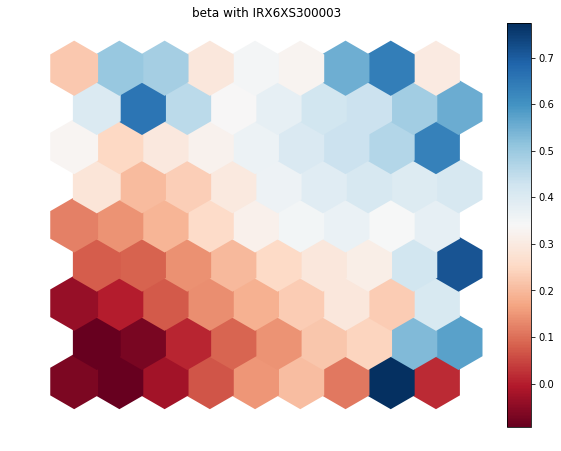

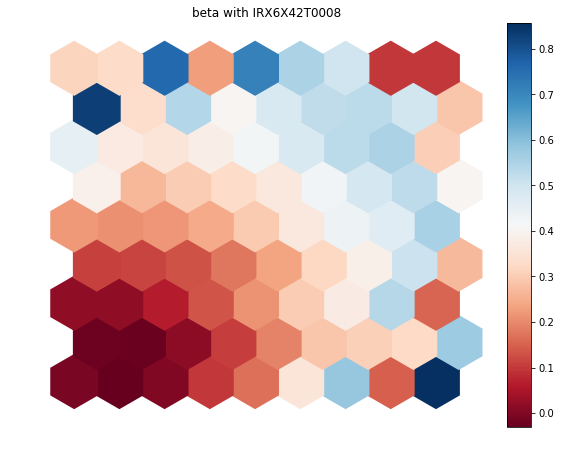

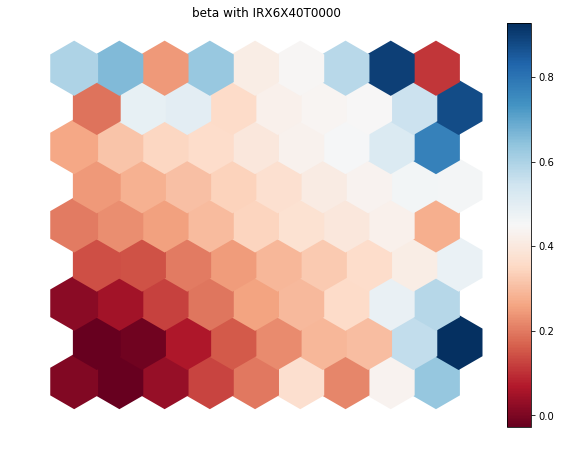

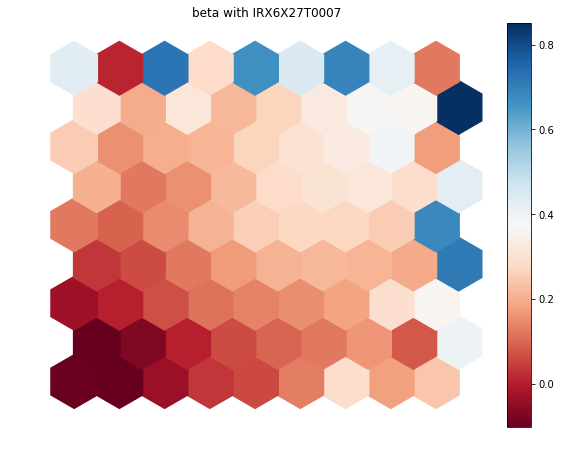

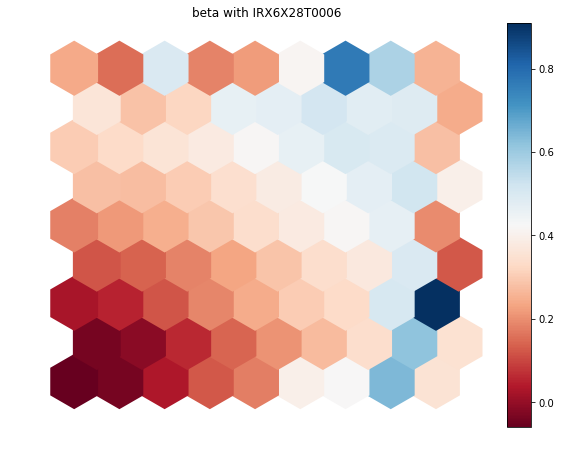

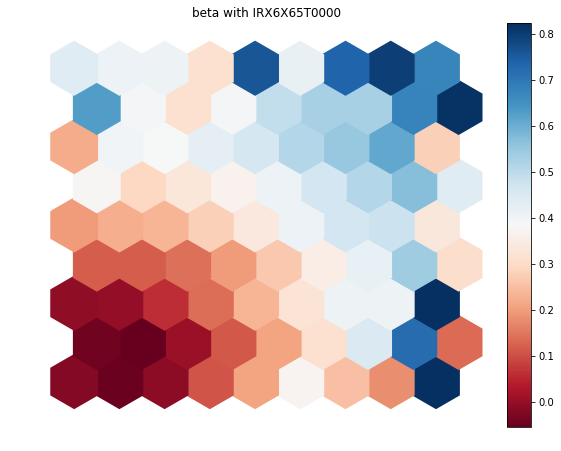

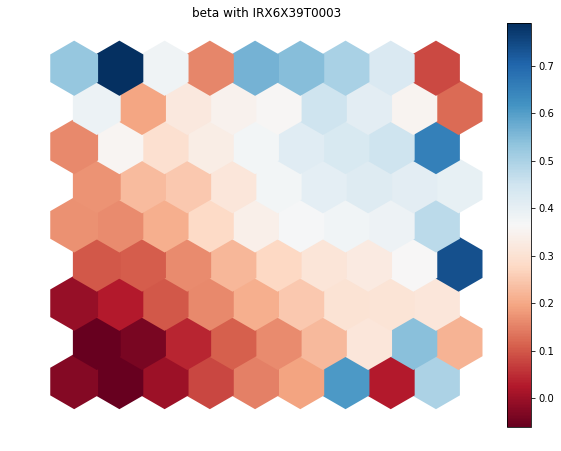

In [252]:
w = som.get_weights()

for f, feature in enumerate(feature_names):
    plot_hex_map(w[:,:,f],titles=feature, comp_width=9, colormap='RdBu')

In [266]:
import math

import numpy as np
from matplotlib import cm, pyplot as plt
from matplotlib.collections import RegularPolyCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_hex_map(d_matrix, titles=[], colormap=cm.gray, shape=[1, 1], comp_width=5, hex_shrink=1.0, fig=None,
                 colorbar=True):
    """
    Plot hexagon map where each neuron is represented by a hexagon. The hexagon
    color is given by the distance between the neurons (D-Matrix)
    Args:
    - grid: Grid dictionary (keys: centers, x, y ),
    - d_matrix: array contaning the distances between each neuron
    - w: width of the map in inches
    - title: map title
    Returns the Matplotlib SubAxis instance
    """

    d_matrix = np.flip(d_matrix, axis=0)

    def create_grid_coordinates(x, y):
        coordinates = [x for row in -1 * np.array(list(range(x))) for x in
                       list(zip(np.arange(((row) % 2) * 0.5, y + ((row) % 2) * 0.5), [0.8660254 * (row)] * y))]
        return (np.array(list(reversed(coordinates))), x, y)

    if d_matrix.ndim < 3:
        d_matrix = np.expand_dims(d_matrix, 2)

    if len(titles) != d_matrix.shape[2]:
        titles = [""] * d_matrix.shape[2]

    n_centers, x, y = create_grid_coordinates(*d_matrix.shape[:2])

    # Size of figure in inches
    if fig is None:
        xinch, yinch = comp_width * shape[1], comp_width * (x / y) * shape[0]
        fig = plt.figure(figsize=(xinch, yinch), dpi=72.)

    for comp, title in zip(range(d_matrix.shape[2]), titles):
        ax = fig.add_subplot(shape[0], shape[1], comp + 1, aspect='equal')

        # Get pixel size between two data points
        xpoints = n_centers[:, 0]
        ypoints = n_centers[:, 1]
        ax.scatter(xpoints, ypoints, s=0.0, marker='s')
        ax.axis([min(xpoints) - 1., max(xpoints) + 1.,
                 min(ypoints) - 1., max(ypoints) + 1.])
        xy_pixels = ax.transData.transform(np.vstack([xpoints, ypoints]).T)
        xpix, ypix = xy_pixels.T

        # discover radius and hexagon
        apothem = hex_shrink * (xpix[1] - xpix[0]) / math.sqrt(3)
        area_inner_circle = math.pi * (apothem ** 2)
        dm = d_matrix[:, :, comp].reshape(np.multiply(*d_matrix.shape[:2]))
        collection_bg = RegularPolyCollection(
            numsides=6,  # a hexagon
            rotation=0,
            sizes=(area_inner_circle,),
            array=dm,
            cmap=colormap,
            offsets=n_centers,
            transOffset=ax.transData,
        )
        ax.add_collection(collection_bg, autolim=True)

        ax.axis('off')
        ax.autoscale_view()
        ax.set_title(titles)#, fontdict={"fontsize": 3 * comp_width})
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(collection_bg, cax=cax)
        if not colorbar:
            cbar.remove()

        #cbar.ax.tick_params(labelsize=3 * comp_width)

    return ax, list(reversed(n_centers))

In [269]:
        we = w
        um = np.zeros((we.shape[0], we.shape[1]))
        it = np.nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if (ii >= 0 and ii < we.shape[0] and
                            jj >= 0 and jj < we.shape[1]):
                        w_1 = we[ii, jj, :]
                        w_2 = we[it.multi_index]
                        w_f = w_1 - w_2
                        um[it.multi_index] += np.sqrt(np.dot(w_f, w_f.T))
            it.iternext()
        um = um/um.max()

In [ ]:
mp = som.distance_map()


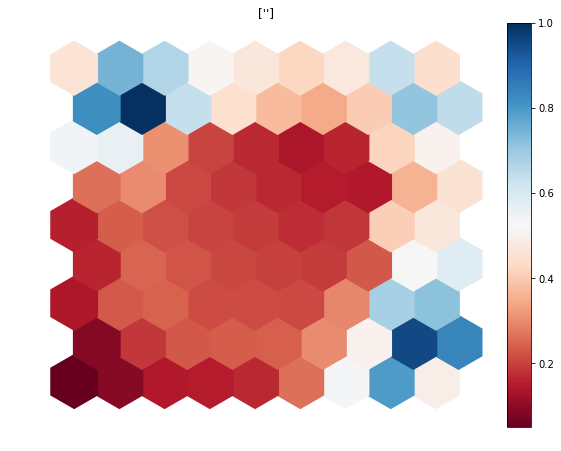

In [270]:
ax, centr = plot_hex_map(mp, comp_width=9, colormap='RdBu')

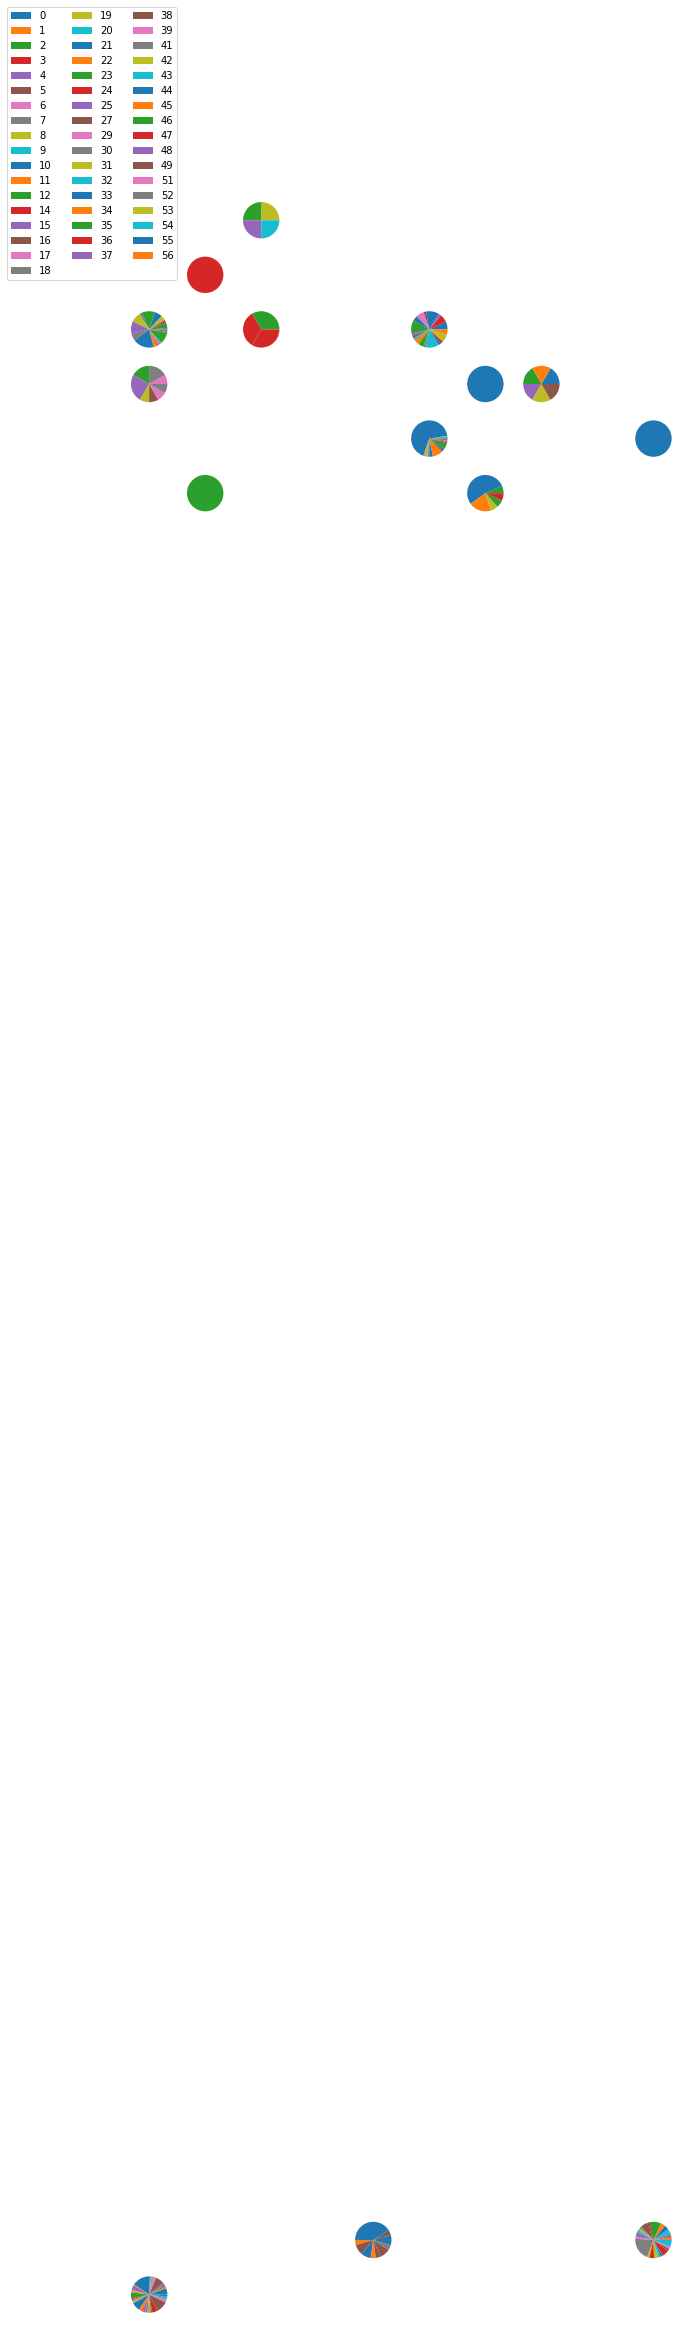

In [272]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

label = target
#labels_map = som.labels_map(data, label)
labels_map = label_map
label_names = np.unique(label)

plt.figure(figsize=(40, 40))
the_grid = GridSpec(40, 40)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    #print(label_fracs)
    plt.subplot(the_grid[6-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
plt.legend(patches, label_names, bbox_to_anchor=(0., 6.5), ncol=3)
#plt.savefig('resulting_images/som_iris_pies.png')
plt.show()



In [255]:
with open('label_map.pkl','rb') as f:
         label_map = pkl.load(f)

In [267]:
label = target
labels_map = label_map
label_names = np.unique(label)

#plt.figure(figsize=(70, 70))
#the_grid = GridSpec(70, 70)
total = []
for position in labels_map.keys():
    #print(position[0])
    label_fracs = [labels_map[position][l] for l in label_names]
    total.append(label_fracs)
    
    
matrix_label = np.zeros((10,10))
print(matrix_label.shape)
#for i in range(som_shape[0]):
    #for j in range(som_shape[1]):
print(len(total))
for i, position in enumerate(labels_map.keys()):

    p_x = position[0]
    p_y = position[1]
    matrix_label[p_x][p_y] = max(total[i])
    #print(matrix_label[p_x][p_y])

(10, 10)
15


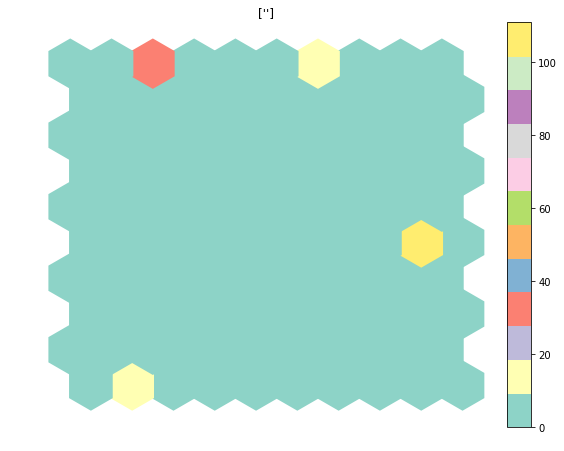

In [268]:
ax, centr = plot_hex_map(matrix_label, comp_width=9, colormap='Set3')